# CoinGame solver using individual actor-critic (IAC) agents

In [128]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
# warnings.filterwarnings('error', message=r".*complex128.*")
# warnings.simplefilter('module')

# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()

import eqmarl
import cirq
import sympy
import tensorflow_quantum as tfq
import numpy as np
import functools as ft
import collections as cl
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import gymnasium as gym
from pathlib import Path
from PIL import Image
import itertools
# from tqdm import tqdm, trange
from tqdm.notebook import tqdm, trange

from typing import Union

In [130]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [131]:
n_agents = 2
n_layers = 5
n_actions = 4 # CoinGame2 has 4 actions (north/south/east/west)
joint_action_map = eqmarl.generate_discrete_joint_action_map(n_agents=n_agents, n_actions=n_actions) # Maps joint action --> per-agent action

In [132]:
# # Individual quantum actors.
# model_actors = [
#     eqmarl.generate_model_CoinGame2_actor_quantum(
#         n_layers=n_layers,
#         name=f"actor-quantum-{i}",
#         )
#     for i in range(n_agents)
# ]

# Individual classical actors.
model_actors = [
    eqmarl.generate_model_CoinGame2_actor_classical(
        n_actions=n_actions,
        units=[128, 64, 32],
        name=f"actor-classical-{i}"
        )
    for i in range(n_agents)
]

for m in model_actors:
    m.build((None, 36))
    m.summary()

Model: "actor-classical-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_26 (Flatten)        (None, 36)                0         
                                                                 
 dense_78 (Dense)            (None, 128)               4736      
                                                                 
 dense_79 (Dense)            (None, 64)                8256      
                                                                 
 dense_80 (Dense)            (None, 32)                2080      
                                                                 
 policy (Dense)              (None, 4)                 132       
                                                                 
Total params: 15,204
Trainable params: 15,204
Non-trainable params: 0
_________________________________________________________________
Model: "actor-classical-1"
__________________

In [133]:

# Individual quantum critics.
model_critics = [
    eqmarl.generate_model_CoinGame2_critic_classical(
        units=[128, 64, 32],
        name=f"critic-classical-{i}",
        )
    for i in range(n_agents)
]

for m in model_critics:
    m.build((None, 36))
    m.summary()



# model_critic = generate_model_CoinGame2_critic([128, 64, 32], name='critic-classical')
# model_critic.build((None, n_agents, 36))
# model_critic.summary()

Model: "critic-classical-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_28 (Flatten)        (None, 36)                0         
                                                                 
 dense_84 (Dense)            (None, 128)               4736      
                                                                 
 dense_85 (Dense)            (None, 64)                8256      
                                                                 
 dense_86 (Dense)            (None, 32)                2080      
                                                                 
 v (Dense)                   (None, 1)                 33        
                                                                 
Total params: 15,105
Trainable params: 15,105
Non-trainable params: 0
_________________________________________________________________
Model: "critic-classical-1"
________________

## Training

In [134]:

class IACController:

    def __init__(self,
        model_actors: list,
        model_critics: list,
        gamma: float,
        optimizer_actor,
        optimizer_critic,
        ):
        self.model_actors = model_actors
        self.model_critics = model_critics
        self.gamma = gamma
        self.optimizer_actor = optimizer_actor
        self.optimizer_critic = optimizer_critic

    def policy(self, states) -> tuple[list, list]:
        joint_action = [] # Actions for all agents.
        joint_action_probs = []
        for i, (s, ma) in enumerate(zip(states, self.model_actors)):
            # Convert to tensor.
            s = tf.convert_to_tensor(s)
            s = tf.reshape(s, (1, *s.shape))
            
            # pi(a | s)
            action_probs = ma(s)
            # print(f"[{i}] {action_probs.numpy()=}")
            # print(f"[{i}] {s.numpy()=}")
            
            # Sample action from estimated probability distribution.
            action = np.random.choice(n_actions, p=np.squeeze(action_probs))
            
            # Add the current action to the joint action list.
            joint_action.append(action)
            joint_action_probs.append(action_probs)
        return joint_action, joint_action_probs

    def values(self, states) -> list:
        joint_state_values = []
        for s, mc in zip(states, self.model_critics):
            # Convert to tensor.
            s = tf.convert_to_tensor(s)
            s = tf.reshape(s, (1, *s.shape))

            # V(s)
            state_values = mc(s)

            # Add the current state value to the joint values list.
            joint_state_values.append(state_values)
        return joint_state_values
    
    def get_expected_returns(self,
        rewards: tf.Tensor,
        standardize: bool = True,
        ) -> tf.Tensor:
        n_rewards = rewards.shape[0]
        
        returns = []
        discounted_sum = 0
        rewards = rewards[::-1] # Reverse the rewards.
        for i in range(n_rewards):
            discounted_sum = rewards[i] + self.gamma * discounted_sum
            returns.append(discounted_sum)
        returns = tf.convert_to_tensor(np.array(returns[::-1], dtype='float32'))
        
        if standardize:
            eps = np.finfo(np.float32).eps.item()
            returns = (returns - tf.math.reduce_mean(returns, axis=0)) / (tf.math.reduce_std(returns, axis=0) + eps)
        
        return returns
    
    def update(self, 
        batched_states: tf.Tensor, # (n_time_steps, n_agents, 36,)
        batched_joint_actions: tf.Tensor,
        batched_joint_action_probs: tf.Tensor,
        batched_next_states: tf.Tensor,
        batched_rewards: tf.Tensor, # (n_time_steps, n_agents,)
        ):
        """Update the models on a batch of data."""
        
        # batch_size = batched_states.shape[0]

        # for b in range(batch_size):
        #     states = batched_states[b]
        #     joint_actions = batched_joint_actions[b]
        #     joint_action_probs = batched_joint_action_probs[b]
        #     next_states = batched_next_states[b]
        #     rewards = batched_rewards[b]
        
        huber_loss = tf.keras.losses.Huber(reduction=keras.losses.Reduction.SUM)
        
        # Pre-compute returns since we already know rewards.
        returns = self.get_expected_returns(batched_rewards, standardize=True)
        
        # Train individual models separately.
        for aidx, (ma, mc) in enumerate(zip(self.model_actors, self.model_critics)):
            with tf.GradientTape() as tape_actor, tf.GradientTape() as tape_critic:
                tape_actor.watch(ma.trainable_variables)
                tape_critic.watch(mc.trainable_variables)
                
                # pi(a | s)
                action_probs = ma(batched_states[:,aidx,:]) # (n_time_steps,n_actions,)
                
                # V(s)
                state_values = mc(batched_states[:,aidx,:])
                
                # Actor loss.
                advantage = returns[:,aidx] - state_values
                id_action_pairs = np.array([(i,a) for i, a in enumerate(batched_joint_actions[:,aidx])]) # (n_time_steps, 2,)
                probs_of_chosen_actions = tf.gather_nd(action_probs, id_action_pairs) # (n_time_steps,)
                action_probs_log = tf.math.log(probs_of_chosen_actions) # (n_time_steps,)
                actor_loss = -tf.math.reduce_sum(action_probs_log * advantage)
                
                # Critic loss.
                critic_loss = huber_loss(state_values, returns[:,aidx])
                
                # # print(f"{advantage=}")
                # print(f"{batched_joint_actions[:,aidx]=}")
                # print(f"{action_probs=}")
                # print(f"{probs_of_chosen_actions=}")
                # print(f"{actor_loss=}")
                # print(f"{critic_loss=}")

            # Compute gradients for both actor and critic.
            actor_grads = tape_actor.gradient(actor_loss, ma.trainable_variables)
            critic_grads = tape_critic.gradient(critic_loss, mc.trainable_variables)
            
            
            # Apply gradients to each model's parameters.
            if isinstance(self.optimizer_actor, (list, tuple)):
                for i in range(len(self.optimizer_actor)):
                    self.optimizer_actor[i].apply_gradients([(actor_grads[i], ma.trainable_variables[i])])
            else:
                self.optimizer_actor.apply_gradients(zip(actor_grads, ma.trainable_variables))
                
            if isinstance(self.optimizer_critic, (list, tuple)):
                for i in range(len(self.optimizer_critic)):
                    self.optimizer_critic[i].apply_gradients([(critic_grads[i], mc.trainable_variables[i])])
            else:
                self.optimizer_critic.apply_gradients(zip(critic_grads, mc.trainable_variables))

In [135]:
class CoinGame2Trainer:

    def __init__(self, env_params):
        self.env = eqmarl.environments.coin_game.coin_game_make(env_params)


    def compute_episode_reward(self, interaction_history: list[dict]) -> float:
        """Episode reward is the sum of all rewards per time step."""
        rewards = np.array([d['rewards'] for d in interaction_history], dtype='float32') # Gather all rewards.
        return np.sum(rewards)


    def run_episode(self, controller) -> tuple[list[dict], dict]:
        """Runs a single episode in the training environment."""
        
        # Reset environment.
        states = self.env.reset()

        interaction_history: list[dict] = []
        while True:

            ####
            ### Interact with environment
            ####

            # Get the 
            joint_action, joint_action_probs = controller.policy(states)

            # Step through environment using joint action.
            next_states, rewards, done, _ = self.env.step(joint_action)

            # Preserve interaction.
            interaction = dict(
                states=states,
                joint_action=joint_action,
                joint_action_probs=joint_action_probs,
                rewards=rewards,
                next_states=next_states,
                done=done,
            )
            interaction_history.append(interaction)
            
            # Set next state.
            states = next_states

            if done:
                break
            
        # Compute environment performance metrics.
        coins_collected = self.env.domain_values()[self.env.get_index('coins_collected')]
        own_coins_collected = self.env.domain_values()[self.env.get_index('own_coins_collected')]
        episode_coins_collected = coins_collected
        episode_own_coins_collected = own_coins_collected
        episode_undiscounted_reward = np.sum(self.env.undiscounted_returns)
        episode_discounted_reward = np.sum(self.env.discounted_returns)
        
        # Compute "own coin rate", and treat all divide by zeros errors as zero.
        if coins_collected != 0:
            episode_own_coin_rate = own_coins_collected/coins_collected
        else:
            episode_own_coin_rate = 0

        # Preserve metrics as dictionary.
        metrics = dict(
            episode_reward=self.compute_episode_reward(interaction_history),
            episode_undiscounted_reward=episode_undiscounted_reward,
            episode_discounted_reward=episode_discounted_reward,
            episode_coins_collected=episode_coins_collected,
            episode_own_coins_collected=episode_own_coins_collected,
            episode_own_coin_rate=episode_own_coin_rate,
        )

        return interaction_history, metrics


    def train(self,
        n_episodes: int, # Number of episodes.
        controller,
        ) -> dict[str, list]:
        
        episode_metrics_history = []
        episode_reward_history = []
        episode_discounted_reward_history = []
        episode_undiscounted_reward_history = []
        episode_coins_collected_history = []
        episode_own_coins_collected_history = []
        episode_own_coin_rate_history = []
        with trange(n_episodes, unit='step') as tepisode:
            for episode in tepisode:
                tepisode.set_description(f"Episode {episode}")
                
                episode_interaction_history, episode_metrics = self.run_episode(controller=controller)
                
                tepisode.set_postfix(**episode_metrics)
                
                # Update the models using the controller.
                batched_rewards = np.array([d['rewards'] for d in episode_interaction_history], dtype='float32').squeeze()
                batched_states = np.array([d['states'] for d in episode_interaction_history]).squeeze()
                batched_next_states = np.array([d['next_states'] for d in episode_interaction_history]).squeeze()
                batched_joint_actions = np.array([d['joint_action'] for d in episode_interaction_history]).squeeze()
                batched_joint_action_probs = np.array([d['joint_action_probs'] for d in episode_interaction_history], dtype='float32').squeeze()

                batched_rewards = tf.convert_to_tensor(batched_rewards)
                batched_states = tf.convert_to_tensor(batched_states)
                batched_next_states = tf.convert_to_tensor(batched_next_states)
                batched_joint_actions = tf.convert_to_tensor(batched_joint_actions)
                batched_joint_action_probs = tf.convert_to_tensor(batched_joint_action_probs)

                # Update controller.
                controller.update(
                    batched_states,
                    batched_joint_actions,
                    batched_joint_action_probs,
                    batched_next_states,
                    batched_rewards,
                )
                
                episode_metrics_history.append(episode_metrics)
                episode_reward_history.append(episode_metrics['episode_reward'])
                episode_discounted_reward_history.append(episode_metrics['episode_discounted_reward'])
                episode_undiscounted_reward_history.append(episode_metrics['episode_undiscounted_reward'])
                episode_coins_collected_history.append(episode_metrics['episode_coins_collected'])
                episode_own_coins_collected_history.append(episode_metrics['episode_own_coins_collected'])
                episode_own_coin_rate_history.append(episode_metrics['episode_own_coin_rate'])
                
                # Report status at regular episodic intervals.
                if (episode+1) % 10 == 0:
                    avg_rewards = np.mean(episode_reward_history[-10:])
                    avg_discounted_rewards = np.mean(episode_discounted_reward_history[-10:])
                    avg_undiscounted_rewards = np.mean(episode_undiscounted_reward_history[-10:])
                    avg_coins_collected = np.mean(episode_coins_collected_history[-10:])
                    avg_own_coins_collected = np.mean(episode_own_coins_collected_history[-10:])
                    avg_own_coin_rate = np.mean(episode_own_coin_rate_history[-10:])
                    msg = "Episode {}/{}, average last 10 rewards {}".format(episode+1, n_episodes, avg_rewards)
                    msg = f"{msg}: {avg_undiscounted_rewards=}, {avg_discounted_rewards=}, {avg_coins_collected=}, {avg_own_coins_collected=}, {avg_own_coin_rate=}"
                    print(msg, flush=True)
                    
                    # Terminate training if score reaches above threshold.
                    # This is to prevent over-training.
                    if avg_rewards > 10:
                        break
        
        # Convert 'list of dicts' to 'dict of lists'.
        episode_metrics_history = {k:[d[k] for d in episode_metrics_history] for k in episode_metrics_history[0].keys()}
        
        return episode_metrics_history
        

n_episodes = 1000
# n_epochs = 2
gamma = 0.95
env_params = {
    "domain_name": "CoinGame-2",
    "R_max": 2,
    # "time_limit": 50,
    "gamma": gamma,
}
trainer = CoinGame2Trainer(env_params=env_params)

optimizer_actor = keras.optimizers.Adam(learning_rate=0.001)
optimizer_critic = keras.optimizers.Adam(learning_rate=0.001)

controller = IACController(
    model_actors=model_actors,
    model_critics=model_critics,
    gamma=gamma,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    )
metrics_history = trainer.train(n_episodes=n_episodes, controller=controller)

  0%|          | 0/1000 [00:00<?, ?step/s]

Episode 10/1000, average last 10 rewards -5.199999809265137: avg_undiscounted_rewards=-5.2, avg_discounted_rewards=-0.5326732371603498, avg_coins_collected=20.4, avg_own_coins_collected=7.6, avg_own_coin_rate=0.3775996810207337
Episode 20/1000, average last 10 rewards 0.30000001192092896: avg_undiscounted_rewards=0.3, avg_discounted_rewards=-0.04874166014081851, avg_coins_collected=23.3, avg_own_coins_collected=11.8, avg_own_coin_rate=0.4931565649812665
Episode 30/1000, average last 10 rewards 1.2999999523162842: avg_undiscounted_rewards=1.3, avg_discounted_rewards=-0.004456676947858507, avg_coins_collected=19.7, avg_own_coins_collected=10.5, avg_own_coin_rate=0.5190094945335633
Episode 40/1000, average last 10 rewards -2.0999999046325684: avg_undiscounted_rewards=-2.1, avg_discounted_rewards=0.20394577737019842, avg_coins_collected=19.3, avg_own_coins_collected=8.6, avg_own_coin_rate=0.45578818595442633
Episode 50/1000, average last 10 rewards 2.200000047683716: avg_undiscounted_rewar

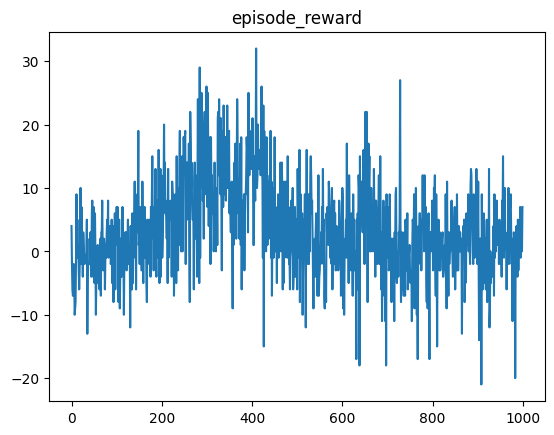

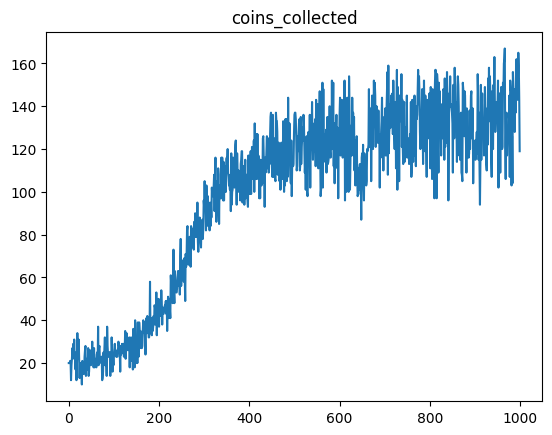

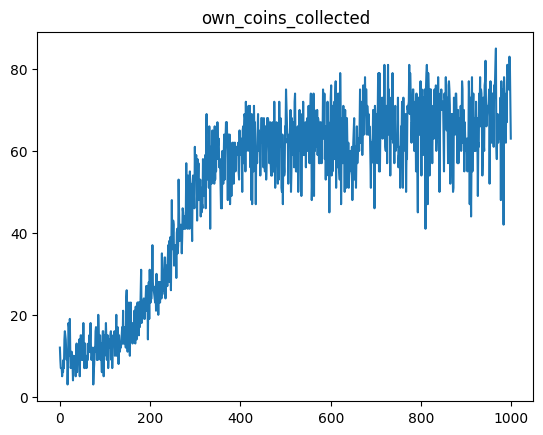

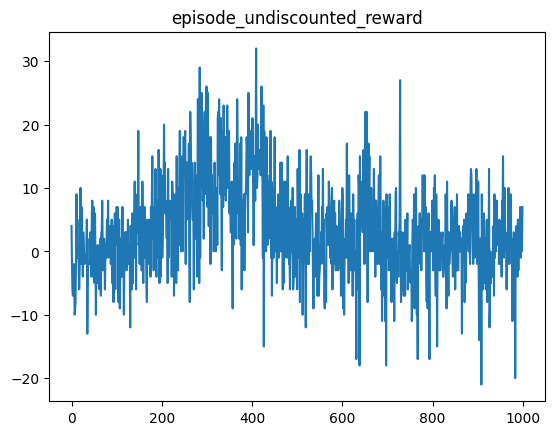

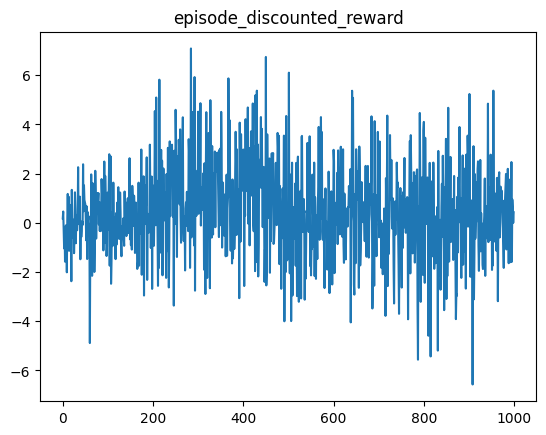

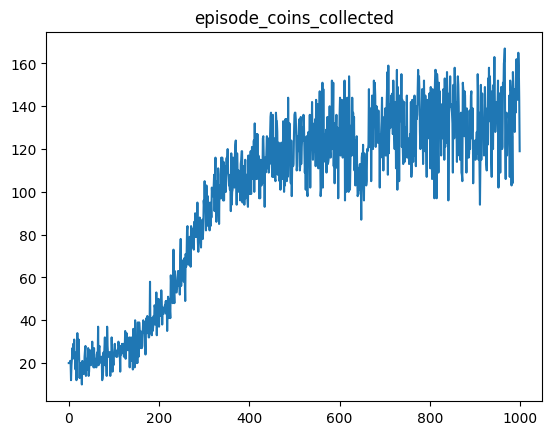

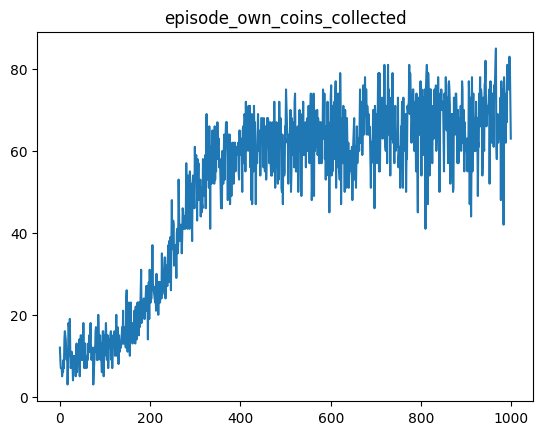

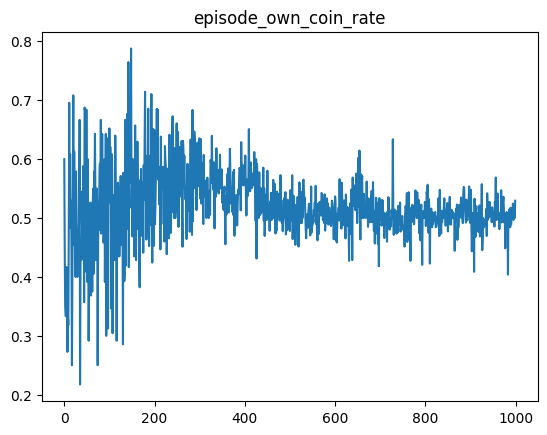

In [136]:
for k, data in metrics_history.items():
    plt.figure()
    plt.plot(data)
    plt.title(k)

## Legacy notebook-based trainer

In [28]:
n_episodes = 300
gamma = 0.99

optimizer_actor = keras.optimizers.Adam(learning_rate=0.001)
optimizer_critic = keras.optimizers.Adam(learning_rate=0.001)


env_params = {
    "domain_name": "CoinGame-2",
    "R_max": 2,
    "time_limit": 50,
    "gamma": gamma,
}
env = eqmarl.environments.coin_game.coin_game_make(env_params)

episode_reward_history = []
step_count = 0

episode_discounted_reward_history = []
episode_undiscounted_reward_history = []
episode_coins_collected_history = []
episode_own_coins_collected_history = []
episode_own_coin_rate_history = []

for episode in range(n_episodes):

    # Reset environment.
    states = env.reset()

    interaction_history = []
    while True:
        
        ####
        ### Interact with environment
        ####
        
        joint_action = [] # Actions for all agents.
        joint_action_probs = []
        joint_state_values = []
        for s, ma, mc in zip(states, model_actors, model_critics):
            # Convert to tensor.
            s = tf.convert_to_tensor(s)
            s = tf.reshape(s, (1, *s.shape))
            
            # pi(a | s)
            action_probs = ma(s)
            
            # V(s)
            state_values = mc(s)
            
            # Sample action from estimated probability distribution.
            action = np.random.choice(n_actions, p=np.squeeze(action_probs))
            
            # Add the current action to the joint action list.
            joint_action.append(action)
            joint_action_probs.append(action_probs)
            joint_state_values.append(state_values)
        
        # Step through environment using joint action.
        next_states, rewards, done, _ = env.step(joint_action)

        # Preserve interaction.
        interaction = dict(
            states=states,
            joint_action=joint_action,
            joint_action_probs=joint_action_probs,
            joint_state_values=joint_state_values,
            rewards=rewards,
            next_states=next_states,
            done=done,
        )
        interaction_history.append(interaction)
        
        if done:
            break

    # Collect information from interaction history.
    states = np.asarray([x['states'] for x in interaction_history]).squeeze()
    joint_actions = np.asarray([x['joint_action'] for x in interaction_history]).squeeze()
    next_states = np.asarray([x['next_states'] for x in interaction_history]).squeeze()
    rewards = np.asarray([x['rewards'] for x in interaction_history], dtype='float32').squeeze()
    joint_action_probs = np.asarray([x['joint_action_probs'] for x in interaction_history], dtype='float32').squeeze()
    joint_state_values = np.asarray([x['joint_state_values'] for x in interaction_history], dtype='float32').squeeze()
    
    states = tf.convert_to_tensor(states)
    joint_actions = tf.convert_to_tensor(joint_actions)
    next_states = tf.convert_to_tensor(next_states)
    rewards = tf.convert_to_tensor(rewards)
    joint_action_probs = tf.convert_to_tensor(joint_action_probs)
    joint_state_values = tf.convert_to_tensor(joint_state_values)
    
    # print(f"{states.shape=}")
    # print(f"{joint_actions.shape=}")
    # print(f"{next_states.shape=}")
    # print(f"{rewards.shape=}")
    # print(f"{joint_action_probs.shape=}")
    # print(f"{joint_state_values.shape=}")
    
    # Episode reward is sum of all individual rewards.
    episode_reward = np.sum(rewards)
    episode_reward_history.append(episode_reward)
    
    # Train individual models separately.
    for aidx, (ma, mc) in enumerate(zip(model_actors, model_critics)):
        with tf.GradientTape() as tape_actor, tf.GradientTape() as tape_critic:
            tape_actor.watch(ma.trainable_variables)
            tape_critic.watch(mc.trainable_variables)
            
            # pi(a | s)
            action_probs = ma(states[:,aidx,:]) # (n_time_steps,n_actions,)
            
            # V(s)
            state_values = mc(states[:,aidx,:])
            
            # Evaluate next-state `s'` for TD error.
            # V(s')
            next_state_values = mc(next_states[:,aidx,:])
            
            # Advantage using TD error.
            # td_target = rewards + (1. - done[...,None]) * gamma * joint_next_state_values
            # td_target = 0
            # for r, vsp in zip(rewards[:,aidx], next_state_values):
            #     td_target += r + gamma * vsp
            # r = tf.convert_to_tensor(rewards[:,aidx,None].squeeze())
            # next_state_values = tf.convert_to_tensor(next_state_values.squeeze())
            # action_probs = tf.convert_to_tensor(action_probs)
            # state_values = tf.convert_to_tensor(state_values.squeeze())
            # print(f"{r=}")
            # print(f"{rewards.dtype=}")
            # print(f"{next_state_values.dtype=}")
            # print(f"{action_probs.shape=}")
            # print(f"{joint_actions[:,aidx].shape=}")
            # print(f"{state_values=}")
            # print(f"{next_state_values.shape=}")
            # print(f"{rewards[:,aidx,None].shape=}")
            td_target = rewards[...,aidx,None] + gamma * next_state_values # (n_time_steps,)
            # td_target = r + gamma * next_state_values # (n_time_steps,)
            advantage = td_target - state_values # (n_time_steps,)
            
            # Compute natural log of action probabilities.
            # action_probs_log = tf.math.log(action_probs) # (n_time_steps, n_actions)
            # print(f"{action_probs[joint_actions[:,aidx]].shape=}")
            id_action_pairs = np.array([(i,a) for i, a in enumerate(joint_actions[:,aidx])]) # (n_time_steps, 2,)
            probs_of_chosen_actions = tf.gather_nd(action_probs, id_action_pairs) # (n_time_steps,)
            action_probs_log = -tf.math.log(probs_of_chosen_actions) # (n_time_steps,)
            # print(f"{a.shape=}")
            # print(f"{p.shape=}")
            # print(f"{rewards[:,aidx,None].shape=}")
            # print(f"{next_state_values.shape=}")
            # print(f"{advantage.shape=}")
            # print(f"{action_probs_log.shape=}")
            
            # Compute actor loss, which is the negative of the sum of log-probabilities multiplied by the advantage.
            # actor_loss = -tf.math.reduce_sum(action_probs_log * advantage)
            actor_loss = tf.math.reduce_sum(action_probs_log * advantage)
            
            # Compute critic loss, which is Huber loss.
            # Inputs to Huber are transposed to have shape (n_agents, n_time_steps), which is automatically reduced to (n_agents,), so no reduction technique is necessary.
            huber_loss = tf.keras.losses.Huber(reduction=keras.losses.Reduction.SUM)
            critic_loss = huber_loss(td_target, state_values)
            
            # print(f"{episode_reward=}")
            # print(f"{td_target.shape=}")
            # print(f"{advantage.shape=}")
            # print(f"{actor_loss=}")
            # print(f"{critic_loss=}")
            
        # # Compute gradients of both losses.
        # for aidx, (ma, mc) in enumerate(zip(model_actors, model_critics)):
        # print(ma.summary())
        # actor_grads = tape_actor.gradient(tf.convert_to_tensor(np.array([3.])), ma.trainable_variables)
        actor_grads = tape_actor.gradient(actor_loss, ma.trainable_variables)
        critic_grads = tape_critic.gradient(critic_loss, mc.trainable_variables)
        
        # print(f"{actor_grads=}")
        
        # Apply gradients to each model's parameters.
        if isinstance(optimizer_actor, (list, tuple)):
            for i in range(len(optimizer_actor)):
                optimizer_actor[i].apply_gradients([(actor_grads[i], ma.trainable_variables[i])])
        else:
            optimizer_actor.apply_gradients(zip(actor_grads, ma.trainable_variables))
            
        if isinstance(optimizer_critic, (list, tuple)):
            for i in range(len(optimizer_critic)):
                optimizer_critic[i].apply_gradients([(critic_grads[i], mc.trainable_variables[i])])
        else:
            optimizer_critic.apply_gradients(zip(critic_grads, mc.trainable_variables))

    # Compute environment performance metrics.
    coins_collected = env.domain_values()[env.get_index('coins_collected')]
    own_coins_collected = env.domain_values()[env.get_index('own_coins_collected')]
    episode_undiscounted_reward = np.sum(env.undiscounted_returns)
    episode_discounted_reward = np.sum(env.discounted_returns)
    episode_coins_collected = coins_collected
    episode_own_coins_collected = own_coins_collected
    
    # Compute "own coin rate", and treat all divide by zeros errors as zero.
    if coins_collected != 0:
        episode_own_coin_rate = own_coins_collected/coins_collected

    episode_discounted_reward_history.append(episode_discounted_reward)
    episode_undiscounted_reward_history.append(episode_undiscounted_reward)
    episode_coins_collected_history.append(episode_coins_collected)
    episode_own_coins_collected_history.append(episode_own_coins_collected)
    episode_own_coin_rate_history.append(episode_own_coin_rate)

    # Report status at regular episodic intervals.
    if (episode+1) % 10 == 0:
        avg_rewards = np.mean(episode_reward_history[-10:])
        avg_discounted_rewards = np.mean(episode_discounted_reward_history[-10:])
        avg_undiscounted_rewards = np.mean(episode_undiscounted_reward_history[-10:])
        avg_coins_collected = np.mean(episode_coins_collected_history[-10:])
        avg_own_coins_collected = np.mean(episode_own_coins_collected_history[-10:])
        avg_own_coin_rate = np.mean(episode_own_coin_rate_history[-10:])
        msg = "Episode {}/{}, average last 10 rewards {}".format(episode+1, n_episodes, avg_rewards)
        msg = f"{msg}: {avg_undiscounted_rewards=}, {avg_discounted_rewards=}, {avg_coins_collected=}, {avg_own_coins_collected=}, {avg_own_coin_rate=}"
        print(msg)

Episode 10/300, average last 10 rewards -0.6000000238418579: avg_undiscounted_rewards=-0.6, avg_discounted_rewards=-0.21181290223173485, avg_coins_collected=21.0, avg_own_coins_collected=10.2, avg_own_coin_rate=0.4805014005602241
Episode 20/300, average last 10 rewards 0.800000011920929: avg_undiscounted_rewards=0.8, avg_discounted_rewards=-0.0910857646807082, avg_coins_collected=19.2, avg_own_coins_collected=10.0, avg_own_coin_rate=0.5180521019109949
Episode 30/300, average last 10 rewards -0.699999988079071: avg_undiscounted_rewards=-0.7, avg_discounted_rewards=-0.11115908316565921, avg_coins_collected=21.3, avg_own_coins_collected=10.3, avg_own_coin_rate=0.4802644087938205
Episode 40/300, average last 10 rewards 1.600000023841858: avg_undiscounted_rewards=1.6, avg_discounted_rewards=0.18967373634088938, avg_coins_collected=18.2, avg_own_coins_collected=9.9, avg_own_coin_rate=0.527870082815735
Episode 50/300, average last 10 rewards -0.20000000298023224: avg_undiscounted_rewards=-0.2

Text(0.5, 1.0, 'Episode Reward')

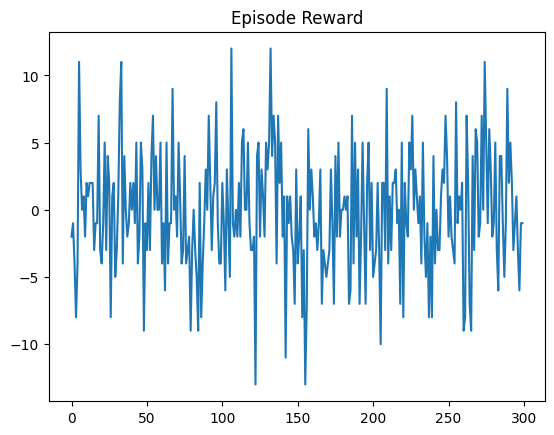

In [101]:
plt.plot(episode_reward_history)
plt.title('Episode Reward')

Text(0.5, 1.0, 'Episode Reward')

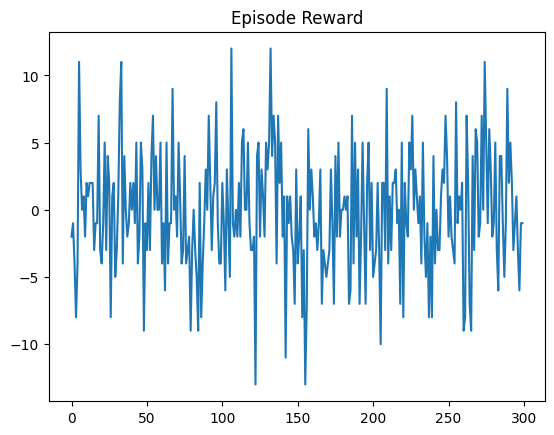

In [102]:
plt.plot(episode_undiscounted_reward_history)
plt.title('Episode Reward')

Text(0.5, 1.0, 'Coins Collected')

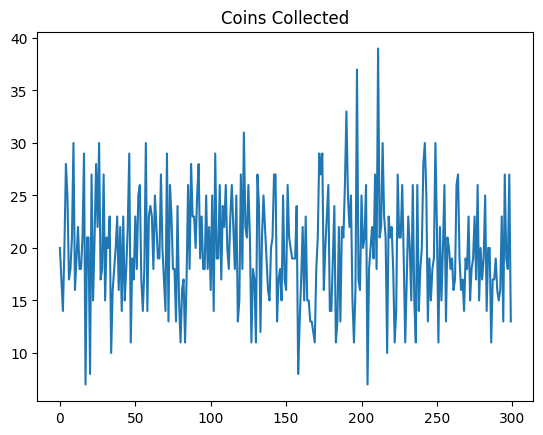

In [103]:
plt.plot(episode_coins_collected_history)
plt.title('Coins Collected')

Text(0.5, 1.0, 'Own Coins Collected')

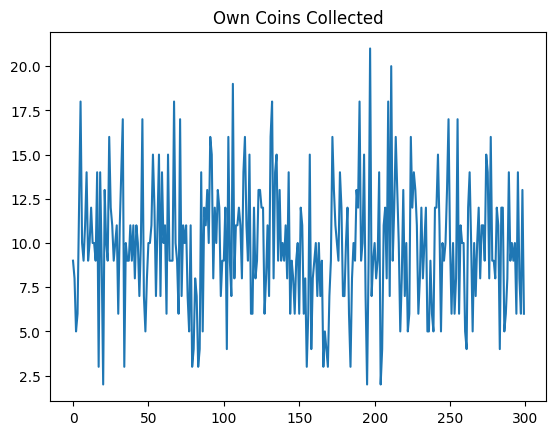

In [104]:
plt.plot(episode_own_coins_collected_history)
plt.title('Own Coins Collected')

Text(0.5, 1.0, 'Own Coin Rate')

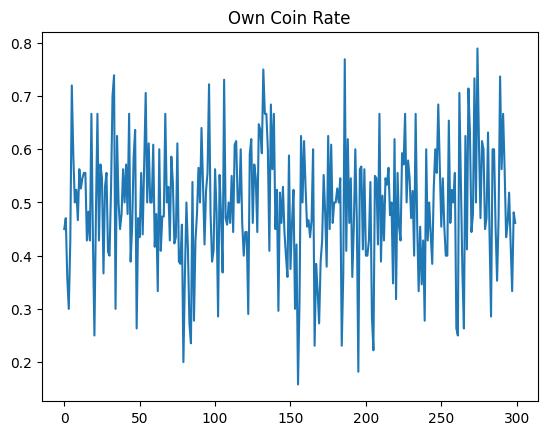

In [105]:
plt.plot(episode_own_coin_rate_history)
plt.title('Own Coin Rate')